## Low-level concepts comparison

In [1]:
import os
#virtually move to parent directory
os.chdir("../")

import torch
import matplotlib
from matplotlib import pyplot as plt
%matplotlib inline

import utils
import data_utils
import similarity

from collections import Counter

# Set font size for plots
font_size = 14
font = {'size': font_size}
matplotlib.rc('font', **font)

In [2]:
target_name = 'plumber'
target_layers = ['projector']
concept_set = 'clip-dissect/concepts/20k.txt'
neurons_to_display = [1,2,3,10,12,16,24,28,133]

## Plotting

In [3]:
with open(concept_set, 'r') as f: 
    words = (f.read()).split('\n')

In [4]:
def get_top_K_neurons(clip_feats, target_feats, similarities, pil_data, K=10, L=5, display=False):
    # Constants
    K = 10  # Top K neurons
    L = 5   # Top L words

    # Compute mean activations across images and find top K neurons
    mean_activations = torch.mean(target_feats, dim=0)
    top_vals, top_neurons = torch.topk(mean_activations, k=K, largest=True)

    # Print the top K neurons and their mean activations
    for i, neuron in enumerate(top_neurons):
        print(f"Neuron {int(neuron)}: {top_vals[i]}")

    # Find top L words for each top K neuron and store in a dictionary
    top_words_dict = {}
    all_top_words = []  # List to accumulate all top words

    for neuron in top_neurons:
        _, top_words = torch.topk(similarities[neuron], k=L, largest=True)
        top_words_dict[int(neuron)] = [words[w] for w in top_words]
        all_top_words.extend(top_words)

        

    print('\n')
    print(f"Top {L} words for each top {K} neuron:")
    # Print the dictionary of top L words for each top K neuron
    for neuron, top_words in top_words_dict.items():
        print(f"Neuron {neuron}: {top_words}")
        
    if display:
        # Plotting top 5 activated images and their words for each top K neuron
        for neuron in top_neurons:
            fig, axs = plt.subplots(nrows=1, ncols=K, figsize=[15, 3])
            fig.suptitle(f"Neuron {int(neuron)}")

            clip_top_word = torch.topk(clip_feats[:, neuron], k=K, largest=True).indices
            top_images = torch.topk(target_feats[:, neuron], k=K, largest=True).indices
            for i, img_id in enumerate(top_images):
                im, label = pil_data[img_id]
                im = im.resize([375, 375])
                axs[i].imshow(im)
                axs[i].axis('off')
                axs[i].set_title(f"CLIP: {words[clip_top_word]}")
            
            plt.tight_layout()

            plt.show()
            
    # Compute unique words and their occurrence frequency
    word_frequency = Counter(all_top_words)

    return word_frequency, top_neurons

In [5]:

def plot_top_k_concepts_neurons(clip_feats, target_feats, similarities, pil_data, K, L, neurons_to_check=None, display=False):
    top_vals, top_ids = torch.topk(target_feats, k=K, dim=0) # top K activations for each neuron , top_ids = [K, 512]
    
    if neurons_to_check is None:
        neurons_to_check = [i for i in range(target_feats.shape[1])]

    all_top_words = []  # List to accumulate all top words

    for j, neuron in enumerate(neurons_to_check):
        # Get the top L words for the neuron
        _, ids = torch.topk(similarities[neuron], k=L, largest=True)
        top_words = [words[int(id)] for id in ids]
        all_top_words.extend(top_words)
        
        if display:
            # Plotting (Optional based on your requirement)
            fig, axs = plt.subplots(nrows=1, ncols=K, figsize=[15, 3])
            fig.suptitle(f"Neuron {int(neuron)}: CLIP-dissect top {L} words: {top_words}")

            clip_top_indices = torch.topk(clip_feats[:, neuron], k=1, largest=True).indices.numpy().tolist()
            clip_top_word = [words[i] for i in clip_top_indices]
            # Iterate over top K images for the neuron
            for i, top_id in enumerate(top_ids[:, neuron]):
                im, label = pil_data[top_id]
                im = im.resize([375, 375])
                axs[i].imshow(im)
                axs[i].axis('off')
                # axs[i].set_title(f"CLIP: {clip_top_word}")

            plt.tight_layout()
            plt.show()

    # Compute unique words and their occurrence frequency
    word_frequency = Counter(all_top_words)

    return word_frequency

In [6]:
clip_name = 'ViT-B/16'
d_probe = 'custom_domainnet'
batch_size = 200
device = 'cuda'
pool_mode = 'max'
domain = 'real'
save_dir = 'saved_activations'
similarity_fn = similarity.soft_wpmi

def do_CLIP_dissect(d_probe, target_name, device, domain):

    save_dir = os.path.join('saved_activations', domain)
    utils.save_activations(clip_name = clip_name, target_name = target_name, target_layers = target_layers, 
                       d_probe = d_probe, concept_set = concept_set, batch_size = batch_size, 
                       device = device, pool_mode=pool_mode, save_dir = save_dir, domain=domain)

    pil_data = data_utils.get_data(d_probe, domain=domain) 

    save_names = utils.get_save_names(clip_name = clip_name, target_name = target_name,
                                  target_layer = target_layers[0], d_probe = d_probe,
                                  concept_set = concept_set, pool_mode=pool_mode,
                                  save_dir = save_dir)

    target_save_name, clip_save_name, text_save_name = save_names

    similarities, target_feats, clip_feats = utils.get_similarity_from_activations(target_save_name, clip_save_name, 
                                                                text_save_name, similarity_fn, device=device)

    return similarities, target_feats, pil_data, clip_feats

## Domain Real

Number of classes in real probe set: 345
Number of images in real probe set: 5044

Number of classes in real probe set: 345
Number of images in real probe set: 5044

Number of classes in real probe set: 345
Number of images in real probe set: 5044

CLIP Image-Text similarity matrix shape: torch.Size([5044, 20000])
Target feature matrix shape: torch.Size([5044, 512])


100%|██████████| 512/512 [00:02<00:00, 240.45it/s]


Target Activation-Concept Similarity matrix shape: torch.Size([512, 20000])
Neuron 133: 41.23045349121094
Neuron 312: 40.941001892089844
Neuron 493: 7.361511707305908
Neuron 425: 6.555020332336426
Neuron 93: 6.504819869995117
Neuron 20: 6.195224761962891
Neuron 504: 6.038704872131348
Neuron 320: 5.681849002838135
Neuron 352: 5.669559478759766
Neuron 488: 5.593505382537842


Top 5 words for each top 10 neuron:
Neuron 133: ['iss', 'rainfall', 'darkness', 'waveform', 'storm']
Neuron 312: ['iss', 'waveform', 'minimal', 'darkness', 'rainfall']
Neuron 493: ['tobago', 'ocean', 'sea', 'caribbean', 'oceanic']
Neuron 425: ['fence', 'harp', 'fences', 'grille', 'instrument']
Neuron 93: ['landscaping', 'fence', 'arbor', 'backyard', 'gardens']
Neuron 20: ['ceilings', 'frames', 'ceiling', 'minimal', 'frameworks']
Neuron 504: ['microwave', 'appliances', 'lcd', 'oven', 'appliance']
Neuron 320: ['violin', 'fireplaces', 'fireplace', 'musician', 'instruments']
Neuron 352: ['packaging', 'handmade', 'crafts

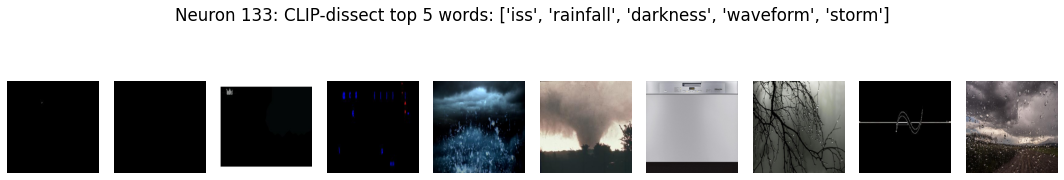

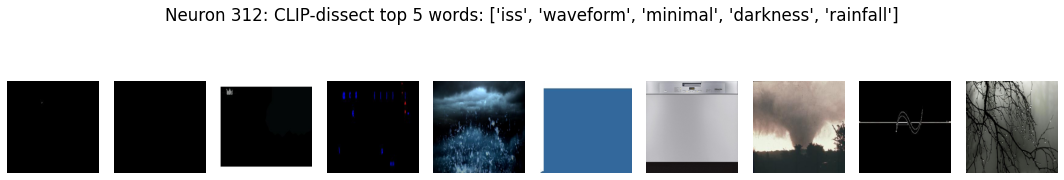

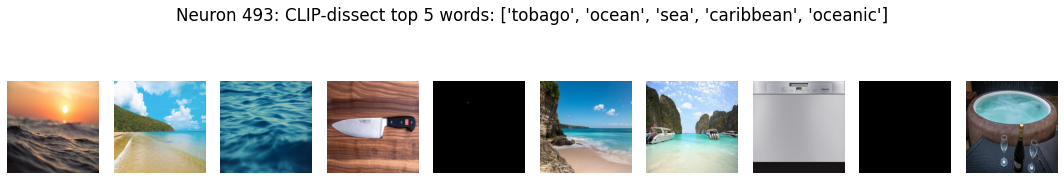

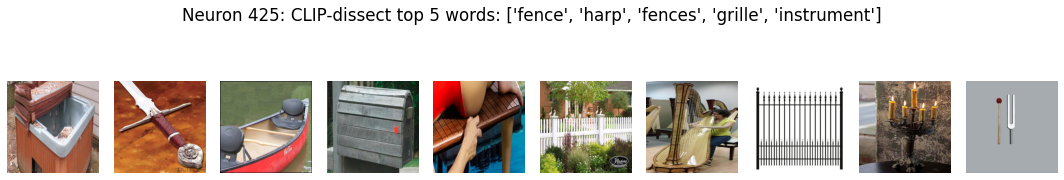

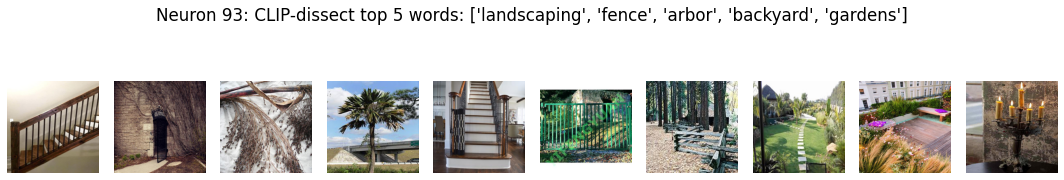

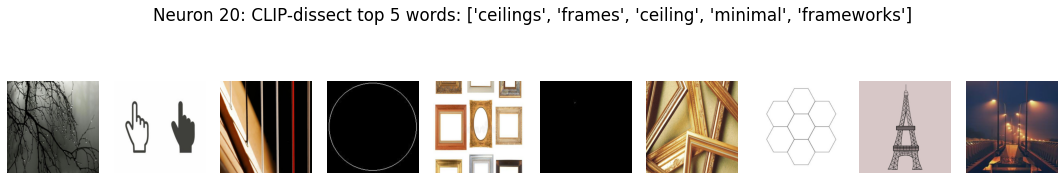

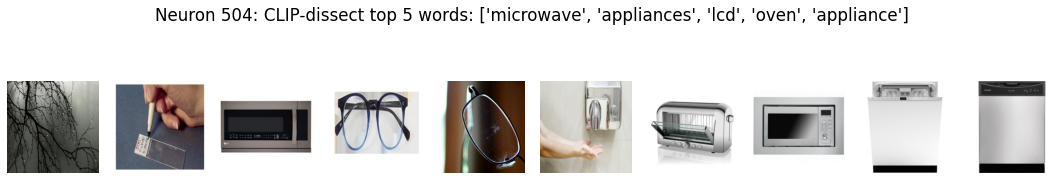

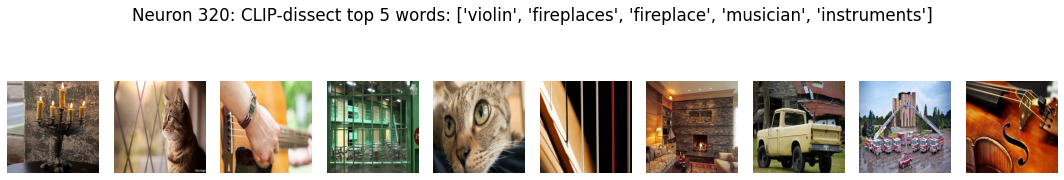

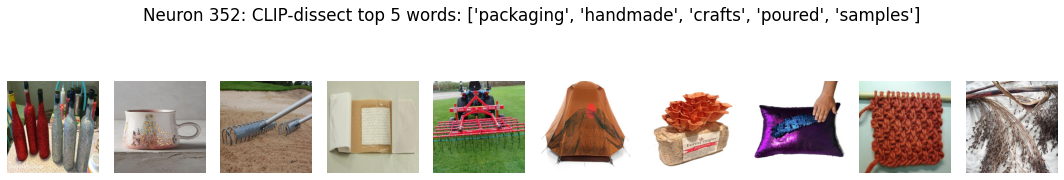

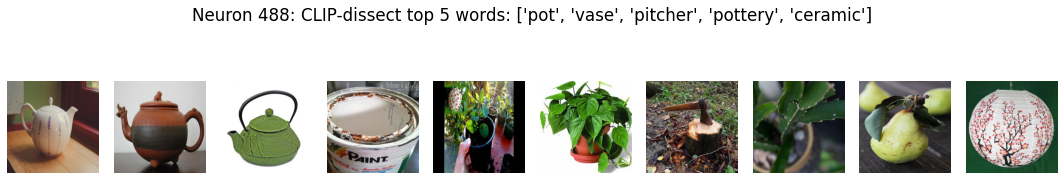

In [7]:
similarities, target_feats, pil_data, clip_feats = do_CLIP_dissect(d_probe, target_name, device, domain='real')
top_neuron_word_frequency, top_neurons = get_top_K_neurons(clip_feats, target_feats, similarities, pil_data, K=10, L=5)
print('\n#############################################\n')
complete_word_frequency = plot_top_k_concepts_neurons(clip_feats, target_feats, similarities=similarities, K=10, L=5, pil_data=pil_data, neurons_to_check=top_neurons, display=True)

# print("Top 10 words and their frequencies:")
# for word, freq in complete_word_frequency.items():
#     print(f"{word}: {freq}")

## Domain- Sketch

Number of classes in sketch probe set: 345
Number of images in sketch probe set: 1946

Number of classes in sketch probe set: 345
Number of images in sketch probe set: 1946

Number of classes in sketch probe set: 345
Number of images in sketch probe set: 1946

CLIP Image-Text similarity matrix shape: torch.Size([1946, 20000])
Target feature matrix shape: torch.Size([1946, 512])


100%|██████████| 512/512 [00:01<00:00, 256.44it/s]


Target Activation-Concept Similarity matrix shape: torch.Size([512, 20000])
Neuron 133: 26.250308990478516
Neuron 312: 26.142240524291992
Neuron 20: 8.243824005126953
Neuron 504: 6.8395586013793945
Neuron 471: 6.3144121170043945
Neuron 160: 5.86513614654541
Neuron 1: 5.554527282714844
Neuron 402: 5.284858703613281
Neuron 292: 5.268495559692383
Neuron 12: 5.252379417419434


Top 5 words for each top 10 neuron:
Neuron 133: ['arabidopsis', 'tree', 'waveform', 'trees', 'branches']
Neuron 312: ['arabidopsis', 'waveform', 'tree', 'trees', 'branches']
Neuron 20: ['tree', 'banner', 'mudvayne', 'branches', 'arabidopsis']
Neuron 504: ['graphite', 'sketches', 'drawing', 'pencils', 'layouts']
Neuron 471: ['symbol', 'flower', 'emblem', 'monogram', 'plant']
Neuron 160: ['studies', 'sketches', 'layouts', 'thumbnails', 'gesture']
Neuron 1: ['tree', 'trees', 'arabidopsis', 'branches', 'pathway']
Neuron 402: ['gesture', 'hands', 'hand', 'studies', 'thumbs']
Neuron 292: ['graphite', 'branches', 'drawings

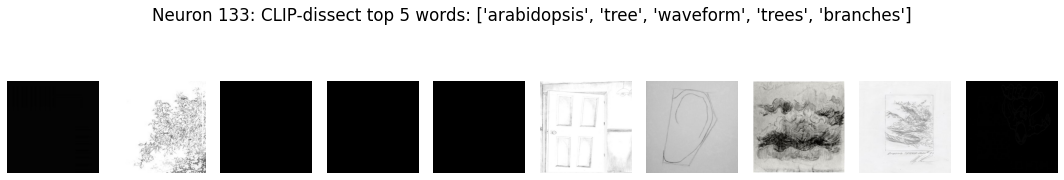

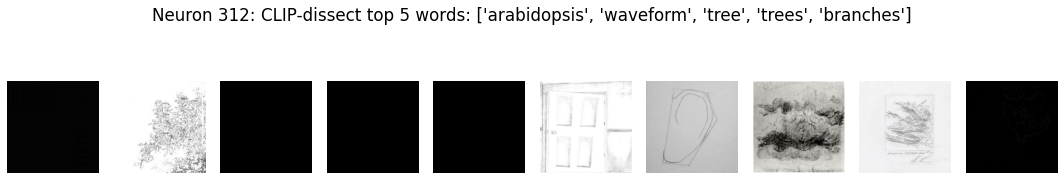

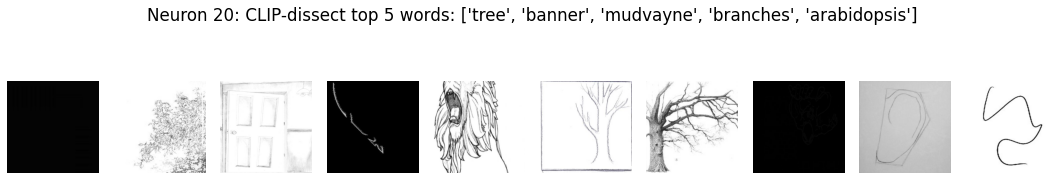

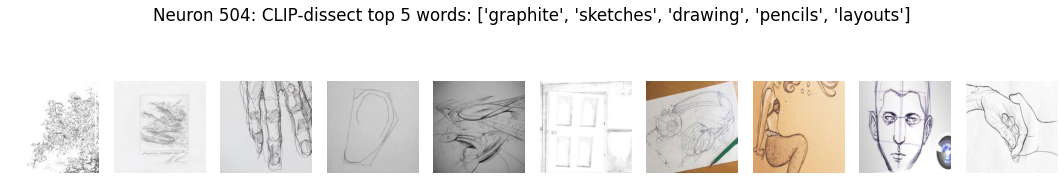

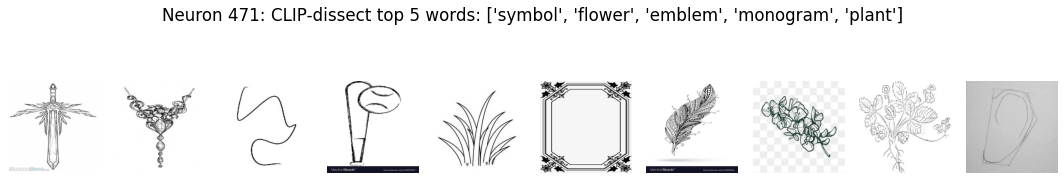

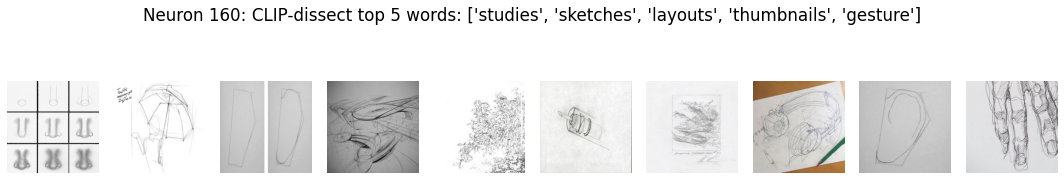

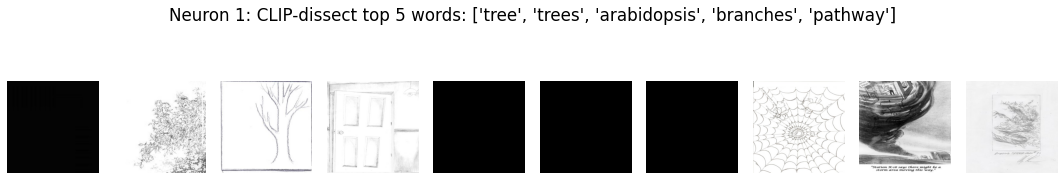

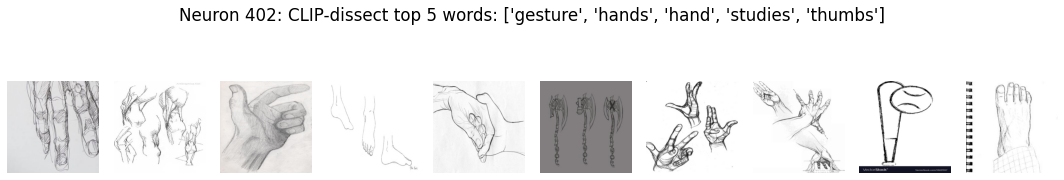

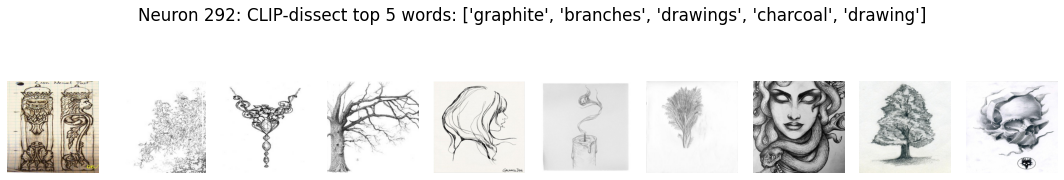

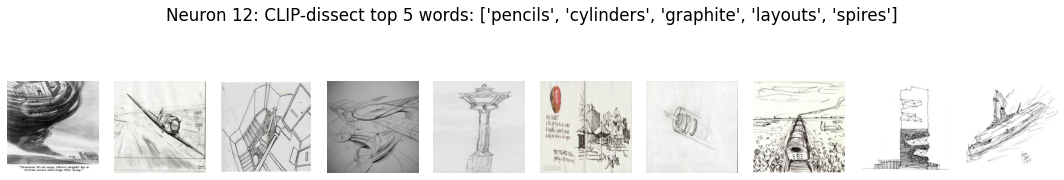

In [8]:
similarities, target_feats, pil_data, clip_feats = do_CLIP_dissect(d_probe, target_name, device, domain='sketch')

top_neuron_word_frequency, top_neurons = get_top_K_neurons(clip_feats, target_feats, similarities, pil_data, K=10, L=5)
print('\n#############################################\n')
complete_word_frequency = plot_top_k_concepts_neurons(clip_feats, target_feats, similarities=similarities, K=10, L=5, pil_data=pil_data, neurons_to_check=top_neurons, display=True)

# print("Top 10 words and their frequencies:")
# for word, freq in complete_word_frequency.items():
#     print(f"{word}: {freq}")

## Painting

Number of classes in painting probe set: 344
Number of images in painting probe set: 2062

Number of classes in painting probe set: 344
Number of images in painting probe set: 2062

Number of classes in painting probe set: 344
Number of images in painting probe set: 2062

CLIP Image-Text similarity matrix shape: torch.Size([2062, 20000])
Target feature matrix shape: torch.Size([2062, 512])


100%|██████████| 512/512 [00:01<00:00, 260.73it/s]


Target Activation-Concept Similarity matrix shape: torch.Size([512, 20000])
Neuron 312: 36.47269821166992
Neuron 133: 36.44581985473633
Neuron 253: 7.566483020782471
Neuron 488: 7.19002628326416
Neuron 509: 7.0055108070373535
Neuron 93: 6.721435546875
Neuron 20: 6.488902568817139
Neuron 1: 6.237277030944824
Neuron 352: 6.121578216552734
Neuron 504: 6.037182331085205


Top 5 words for each top 10 neuron:
Neuron 312: ['particles', 'abstracts', 'abstraction', 'neurons', 'particle']
Neuron 133: ['particles', 'abstraction', 'abstracts', 'neurons', 'particle']
Neuron 253: ['tiger', 'coil', 'serpent', 'abstraction', 'abstracts']
Neuron 488: ['ornament', 'ornaments', 'acorn', 'ornamental', 'beaded']
Neuron 509: ['richter', 'abstraction', 'veil', 'abstracts', 'detail']
Neuron 93: ['harvest', 'picnic', 'rural', 'cottage', 'portage']
Neuron 20: ['coil', 'particles', 'abstraction', 'abstracts', 'particle']
Neuron 1: ['abstracts', 'abstraction', 'abstract', 'transistor', 'coil']
Neuron 352: ['bild'

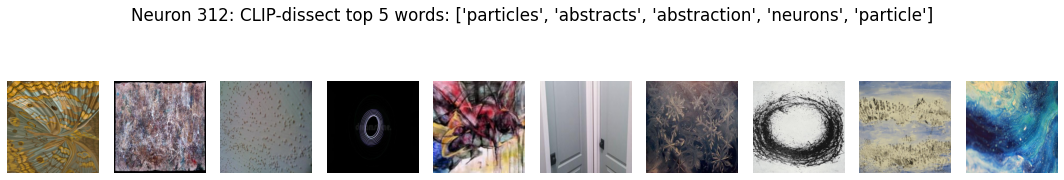

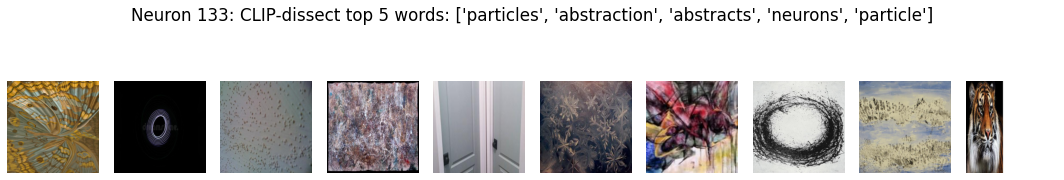

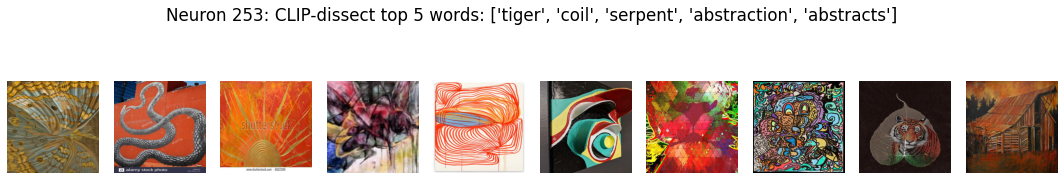

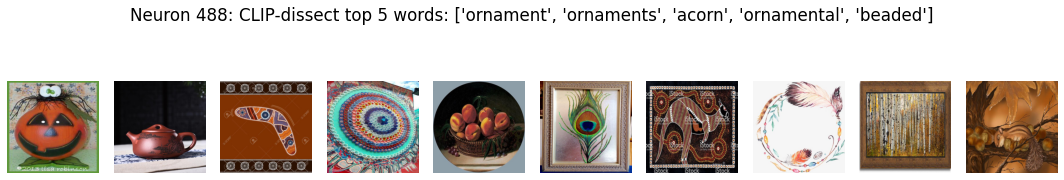

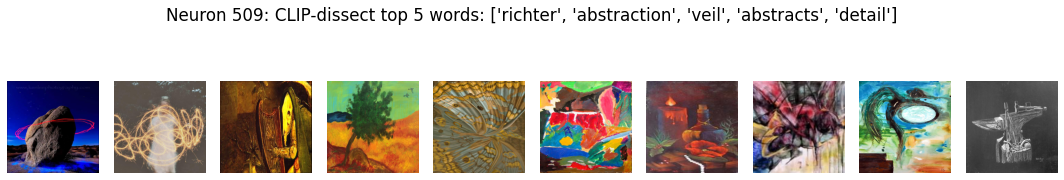

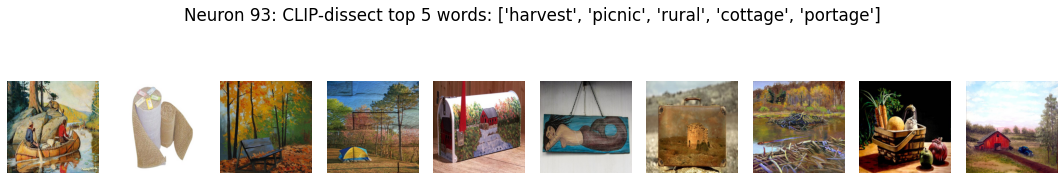

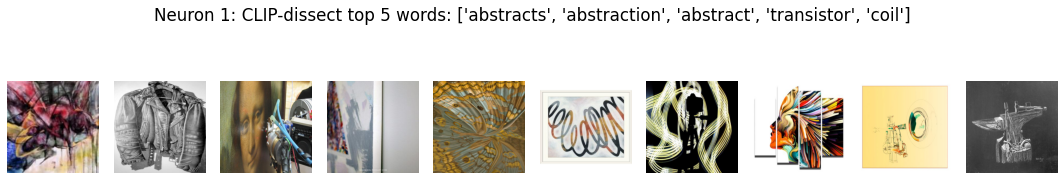

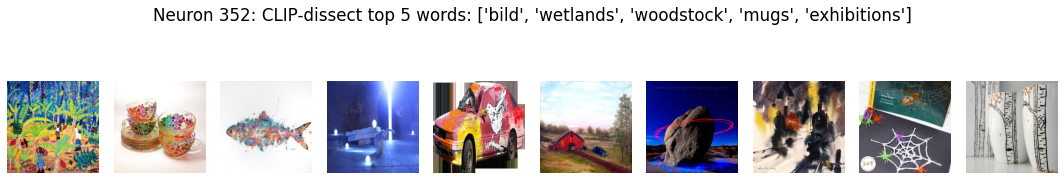

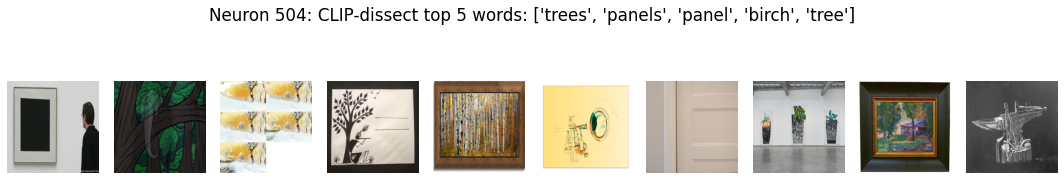

In [9]:
similarities, target_feats, pil_data, clip_feats = do_CLIP_dissect(d_probe, target_name, device, domain='painting')

top_neuron_word_frequency, top_neurons = get_top_K_neurons(clip_feats, target_feats, similarities, pil_data, K=10, L=5)
print('\n#############################################\n')
complete_word_frequency = plot_top_k_concepts_neurons(clip_feats, target_feats, similarities=similarities, K=10, L=5, pil_data=pil_data, neurons_to_check=top_neurons, display=True)

# print("Top 10 words and their frequencies:")
# for word, freq in complete_word_frequency.items():
#     print(f"{word}: {freq}")

## Domain Sketch Painting Clipart

Number of classes in clipart test set: 345
Number of images in clipart test set: 14604

Number of classes in painting test set: 344
Number of images in painting test set: 21850

Number of classes in sketch test set: 345
Number of images in sketch test set: 20916

Number of classes in clipart test set: 345
Number of images in clipart test set: 14604

Number of classes in painting test set: 344
Number of images in painting test set: 21850

Number of classes in sketch test set: 345
Number of images in sketch test set: 20916

Number of classes in clipart test set: 345
Number of images in clipart test set: 14604

Number of classes in painting test set: 344
Number of images in painting test set: 21850

Number of classes in sketch test set: 345
Number of images in sketch test set: 20916

CLIP Image-Text similarity matrix shape: torch.Size([20000, 20000])
Target feature matrix shape: torch.Size([20000, 512])


100%|██████████| 512/512 [00:02<00:00, 250.29it/s]


Target Activation-Concept Similarity matrix shape: torch.Size([512, 20000])
Neuron 133: 39.12405014038086
Neuron 312: 38.98134231567383
Neuron 20: 9.477598190307617
Neuron 471: 8.42043399810791
Neuron 253: 7.934667110443115
Neuron 504: 7.55327033996582
Neuron 493: 7.42501163482666
Neuron 1: 7.420220375061035
Neuron 379: 6.8480224609375
Neuron 488: 6.8116068840026855


Top 5 words for each top 10 neuron:
Neuron 133: ['bulbs', 'bucket', 'bulb', 'pot', 'vase']
Neuron 312: ['bulb', 'bucket', 'bulbs', 'vase', 'pot']
Neuron 20: ['stove', 'stoves', 'scorpio', 'illustration', 'articulated']
Neuron 471: ['fireplace', 'fireplaces', 'mantle', 'chimney', 'stoves']
Neuron 253: ['softcover', 'decorating', 'decorative', 'framed', 'conservatory']
Neuron 504: ['diocese', 'palau', 'svg', 'guiana', 'tokelau']
Neuron 493: ['indicator', 'ambulance', 'indicators', 'leukemia', 'signaling']
Neuron 1: ['intervals', 'tracked', 'sudoku', 'compose', 'surface']
Neuron 379: ['defence', 'defense', 'defenses', 'orche

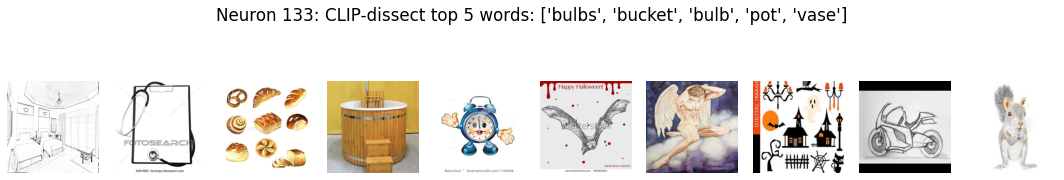

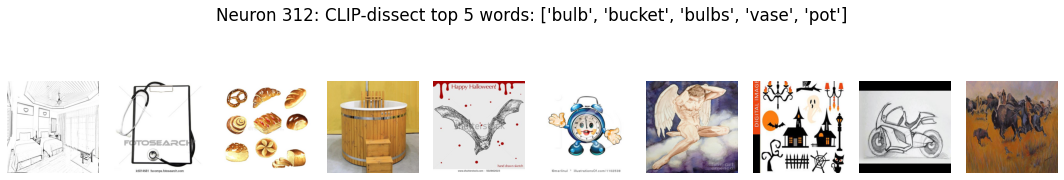

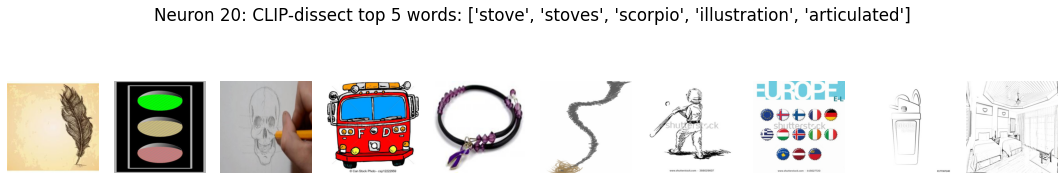

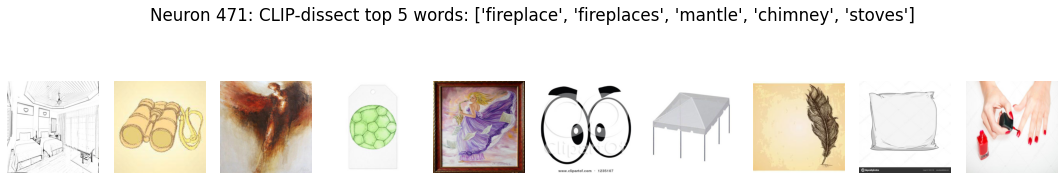

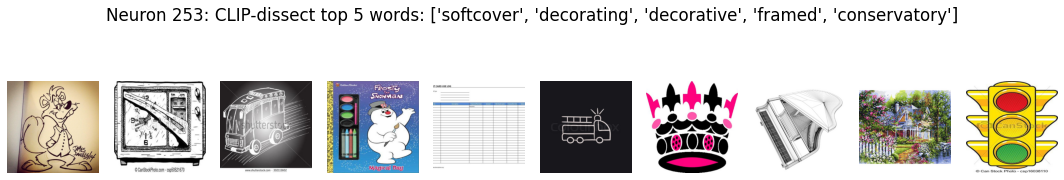

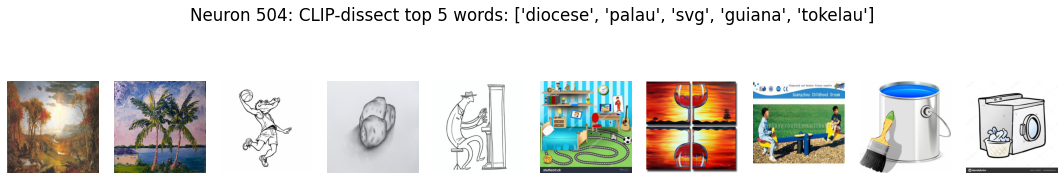

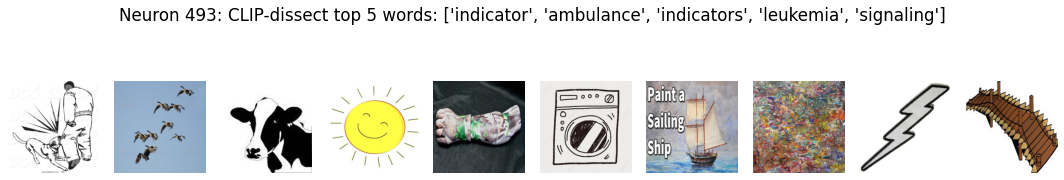

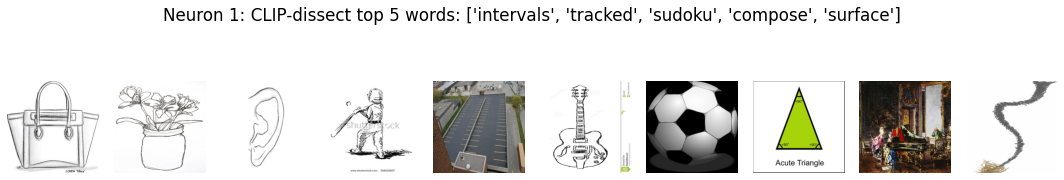

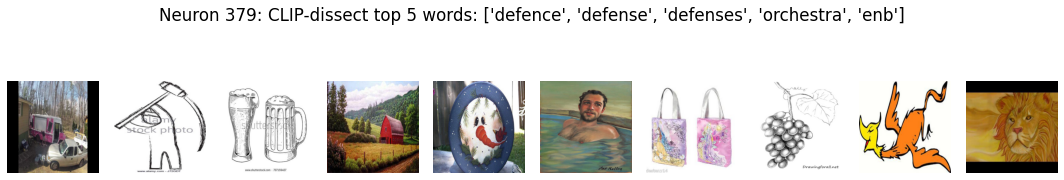

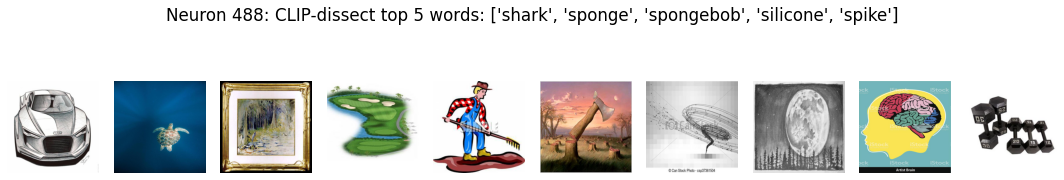

In [10]:

similarities, target_feats, pil_data, clip_feats = do_CLIP_dissect(d_probe, target_name, device, domain='spc')

top_neuron_word_frequency, top_neurons = get_top_K_neurons(clip_feats, target_feats, similarities, pil_data, K=10, L=5)
print('\n#############################################\n')
complete_word_frequency = plot_top_k_concepts_neurons(clip_feats, target_feats, similarities=similarities, K=10, L=5, pil_data=pil_data, neurons_to_check=top_neurons, display=True)
